In [1]:
!nvidia-smi

Sat Sep 20 21:49:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0  On |                  N/A |
| 30%   42C    P8             32W /  350W |     160MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
try:
    from vllm.distributed.parallel_state import (
        destroy_model_parallel,
        destroy_distributed_environment,
    )
    import vllm
#    !export VLLM_LOGGING_LEVEL=ERROR

    print(f"Successfully imported vllm version: {vllm.__version__}")
    USE_VLLM = True
except ImportError as e:
    print(f"An error occurred: {e}")
    USE_VLLM = False

INFO 09-20 21:49:15 [__init__.py:216] Automatically detected platform cuda.
Successfully imported vllm version: 0.10.2


In [3]:
import torch
import trl
import bitsandbytes

print(f"Using PyTorch version: {torch.__version__}")
print(f"Using TRL version: {trl.__version__}")
print(f"Using bitsandbytes version: {bitsandbytes.__version__}")

Using PyTorch version: 2.8.0+cu128
Using TRL version: 0.23.0
Using bitsandbytes version: 0.47.0


In [4]:
import os
import gc
import sys
import warnings
import contextlib
from huggingface_hub import login
from datasets import load_dataset, Dataset
import gc
import random
import re
import json
import re
import torch
import logging
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import GRPOConfig, GRPOTrainer, SFTConfig, SFTTrainer
from peft import LoraConfig
from tqdm import tqdm

In [5]:
if 'google.colab' in sys.modules:
    from google.colab import userdata
    from huggingface_hub import login

    # Access the secret
    # Make sure you have created a secret named 'HUGGING_FACE_HUB_TOKEN' in your Colab secrets
    hf_token = userdata.get("HF_TOKEN")

    # Log in to Hugging Face
    # The 'token' parameter is used for non-interactive login
    login(token=hf_token)

    print("Hugging Face login successful!")

In [6]:
def silence_annoying_logs():
    """
    Silences INFO and WARNING messages from specific libraries.
    This is a robust method that handles placeholder loggers.
    """
    # List of logger prefixes to silence
    loggers_to_silence = ["vllm", "numba"]  # Added numba as it can also be noisy

    for name, logger in logging.root.manager.loggerDict.items():
        # Check if the logger name starts with any of the prefixes
        if any(name.startswith(prefix) for prefix in loggers_to_silence):
            # IMPORTANT: Check if it's a real logger and not a placeholder
            if isinstance(logger, logging.Logger):
                logger.setLevel(logging.ERROR)


# Also, let's suppress the UserWarning from numba if it appears
warnings.filterwarnings("ignore", category=UserWarning, module="numba")


# Call the function to apply the changes
silence_annoying_logs()

In [7]:
# --- System Prompts and Formatting (JSON-Only) ---

# A clear and direct instruction for the AI's role and task.
SYSTEM_PROMPT_HEADER = """You are a financial analyst AI. Your task is to analyze the sentiment of the provided financial news snippet."""

# Specific instructions on the output format.
JSON_STRUCTURE_INSTRUCTIONS = """Your response MUST be a single, valid JSON object containing two keys:
1. `sentiment`: Must be one of "positive", "negative", or "neutral".
2. `explanation`: A brief justification for the sentiment, under 50 words."""

# A perfect example of the desired output.
EXAMPLE_JSON = """{
  "sentiment": "positive",
  "explanation": "The company announced record profits and a successful product launch, indicating strong positive performance."
}"""

# Combine all parts into the final system prompt.
SYSTEM_PROMPT = (
    SYSTEM_PROMPT_HEADER
    + "\n\n"
    + JSON_STRUCTURE_INSTRUCTIONS
    + "\n\n"
    + "Here is an example of the required output format:\n"
    + EXAMPLE_JSON
)

In [8]:
# --- Configuration Class ---

class Config:
    """Configuration parameters"""

    SIZE = "3-270m"
    #SIZE = "3-1b"
    MODEL_NAME = f"google/gemma-{SIZE}-it"
    OUTPUT_MODEL = f"gemma-{SIZE}-it-grpo-finsent-json"

    max_prompt_length = 1024
    max_completion_length = 512


# --- Environment and Utility Functions ---


def init():
    """Initialization script"""
    os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

    # It is recommended to set the HF_TOKEN as an environment variable
    token = os.environ.get("HF_TOKEN")
    if token:
        login(token=token)
    else:
        print("HF_TOKEN not set. You might need to log in manually.")

    torch.cuda.empty_cache()
    gc.collect()
    warnings.filterwarnings("ignore")


def close(llm=None):
    """Close vllm and clean up resources"""
    destroy_model_parallel()
    destroy_distributed_environment()
    if llm:
        del llm.llm_engine.model_executor
        del llm
    with contextlib.suppress(AssertionError):
        torch.distributed.destroy_process_group()
    gc.collect()
    torch.cuda.empty_cache()


def is_bfloat16_supported():
    """Checks if the current device supports bfloat16."""
    return torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8


def info_device():
    """Get device for PyTorch"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

In [9]:
init()
params = Config()
device = info_device()
dtype = torch.bfloat16 if is_bfloat16_supported() else torch.float16

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Using device: cuda


In [10]:
def get_fpb_questions(split="train"):
    """Upload FinancialPhraseBank dataset"""
    repo_id = "lmassaron/FinancialPhraseBank"
    data = load_dataset(repo_id, cache_dir="/tmp")[split]

    data = data.map(
        lambda x: {
            "prompt": [
                {"role": "user", "content": SYSTEM_PROMPT + "\n[" + x["sentence"]+"]"},
            ],
            "answer": x["sentiment"],
        }
    )
    data = data.remove_columns(["sentiment", "sentence", "label"])
    return data

In [11]:
# Let's load a small sample of the GSM8K data to see its structure.
fpb_sample = get_fpb_questions(split="test").select(range(2))

for response in fpb_sample:
    print("--- PROMPT ---")
    print(response["prompt"][0]["content"])
    print("\n--- GROUND TRUTH ANSWER ---")
    print(response["answer"])
    print("=" * 30)

--- PROMPT ---
You are a financial analyst AI. Your task is to analyze the sentiment of the provided financial news snippet.

Your response MUST be a single, valid JSON object containing two keys:
1. `sentiment`: Must be one of "positive", "negative", or "neutral".
2. `explanation`: A brief justification for the sentiment, under 50 words.

Here is an example of the required output format:
{
  "sentiment": "positive",
  "explanation": "The company announced record profits and a successful product launch, indicating strong positive performance."
}
[The new agreement , which expands a long-established cooperation between the companies , involves the transfer of certain engineering and documentation functions from Larox to Etteplan .]

--- GROUND TRUTH ANSWER ---
positive
--- PROMPT ---
You are a financial analyst AI. Your task is to analyze the sentiment of the provided financial news snippet.

Your response MUST be a single, valid JSON object containing two keys:
1. `sentiment`: Must be 

In [12]:
def extract_json_from_text(text: str) -> dict | None:
    """
    Extracts the last JSON object from a string.
    Handles cases where the JSON is embedded in text or code blocks.
    """
    # Regex to find a JSON object, ignoring potential ```json markers
    matches = re.findall(r"\{[\s\S]*?\}", text)
    if not matches:
        return ""
    try:
        # Return the last found JSON object
        return json.loads(matches[-1])
    except json.JSONDecodeError:
        return ""

In [13]:
# --- New Reward Constants (JSON-Only) ---

# Level 1: JSON Format
# Harshest penalty for failing the basic output format.
PENALTY_INVALID_JSON = -2.0
# A small base reward for getting the format right.
REWARD_VALID_JSON = 0.3

# Level 2: Core Task Correctness
REWARD_SENTIMENT_CORRECT = 1.0
PENALTY_SENTIMENT_WRONG = -1.0
REWARD_SENTIMENT_NEAR = 0.2  # Encouragement for being close

# Level 3: Quality/Style
REWARD_EXPLANATION_QUALITY = 0.8
MIN_REASONING_LEN = 20
MAX_REASONING_LEN = 50  # Adjusted to match prompt

In [14]:
def flatten(completion):
    if not completion:
        return []
    if isinstance(completion[0], list):
        return [item for sublist in completion for item in sublist]
    return completion

In [15]:
def json_format_reward_func(completions, **kwargs):
    """
    Primary gatekeeper. Checks if the output is a valid JSON with the required keys.
    """
    output = flatten(completions)
    rewards = []
    for response in output:
        parsed_json = extract_json_from_text(response["content"])
        if parsed_json and "sentiment" in parsed_json and "explanation" in parsed_json:
            rewards.append(REWARD_VALID_JSON)
        else:
            rewards.append(PENALTY_INVALID_JSON)
    return rewards


def correct_sentiment_func(completions, answer, **kwargs):
    """
    Checks for the correct sentiment within the parsed JSON.
    """
    sentiment_scores = {"positive": 1, "neutral": 0, "negative": -1}
    output = flatten(completions)
    rewards = []
    for response, actual_sentiment in zip(output, answer):
        parsed_json = extract_json_from_text(response["content"])
        if parsed_json and "sentiment" in parsed_json:
            predicted_sentiment = str(parsed_json["sentiment"]).lower()
            if predicted_sentiment in sentiment_scores:
                pred_score = sentiment_scores[predicted_sentiment]
                actual_score = sentiment_scores[actual_sentiment]
                distance = abs(pred_score - actual_score)

                if distance == 0:
                    rewards.append(REWARD_SENTIMENT_CORRECT)
                elif distance == 1:
                    rewards.append(REWARD_SENTIMENT_NEAR)
                else:  # distance == 2
                    rewards.append(PENALTY_SENTIMENT_WRONG)
            else:  # Invalid sentiment value
                rewards.append(PENALTY_SENTIMENT_WRONG)
        else:  # Malformed or missing JSON
            rewards.append(PENALTY_SENTIMENT_WRONG)
    return rewards


def explanation_quality_func(completions, **kwargs):
    """
    Rewards the model for generating an explanation of an ideal length.
    """
    output = flatten(completions)
    rewards = []
    for response in output:
        parsed_json = extract_json_from_text(response["content"])
        if (
            parsed_json
            and "explanation" in parsed_json
            and isinstance(parsed_json["explanation"], str)
        ):
            exp_len = len(parsed_json["explanation"].split())
            if exp_len >= MIN_REASONING_LEN and exp_len <= MAX_REASONING_LEN:
                rewards.append(REWARD_EXPLANATION_QUALITY)
            elif exp_len > 0 and exp_len < MIN_REASONING_LEN:
                rewards.append(
                    REWARD_EXPLANATION_QUALITY * (exp_len / MIN_REASONING_LEN)
                )
            else:
                rewards.append(0.0)  # Too short or too long
        else:
            rewards.append(0.0)  # No quality reward if format is wrong
    return rewards

In [16]:
def test_reward_function(
    model,
    tokenizer,
    test_data,
    num_test_samples,
    device,
    max_visualizations=3,  # New parameter to control output
    temperature=1.0,
    seed=0,
):
    """
    Evaluates the model and reward functions on a random subset of the test data.

    Args:
        model: The model to test.
        tokenizer: The tokenizer for the model.
        test_data: The dataset to sample from.
        num_test_samples: The total number of samples to evaluate.
        device: The device to run inference on.
        max_visualizations (int): The maximum number of detailed outputs to print.
        temperature (float): The generation temperature.
        seed (int): Random seed for reproducibility.
    """
    random.seed(seed)

    # --- Setup for Evaluation and Visualization ---
    random_indices = random.sample(range(len(test_data)), num_test_samples)

    # Randomly select a subset of the test indices to visualize in detail
    # This ensures the visualizations are also a random sample
    visualize_indices = set(
        random.sample(random_indices, k=min(max_visualizations, num_test_samples))
    )

    # --- Data Storage ---
    accuracy_scores = []
    total_rewards = []
    reward_funcs = {
        "json_format": json_format_reward_func,
        "sentiment_correctness": correct_sentiment_func,
        "explanation_quality": explanation_quality_func,
    }
    reward_breakdown = {name: [] for name in reward_funcs.keys()}

    print(
        f"Running evaluation on {num_test_samples} samples. Visualizing {len(visualize_indices)} of them..."
    )

    for i in tqdm(random_indices, desc="Evaluating Samples"):
        sample = test_data[i]
        full_prompt = sample["prompt"][0]["content"]
        ground_truth_sentiment = sample[
            "answer"
        ]  # This is the string "positive", "negative", etc.

        inputs = tokenizer(full_prompt, return_tensors="pt").to(device)

        # Generate a completion from the model
        outputs = model.generate(
            **inputs,
            pad_token_id=tokenizer.eos_token_id,
            max_new_tokens=256,
            temperature=temperature,
            do_sample=True if temperature > 0 else False,
        )
        generated_text = tokenizer.decode(
            outputs[0, inputs.input_ids.shape[-1] :], skip_special_tokens=True
        )

        # --- 1. Calculate Accuracy (More Robust Method) ---
        parsed_json = extract_json_from_text(generated_text)
        if parsed_json and isinstance(parsed_json.get("sentiment"), str):
            predicted_sentiment = parsed_json["sentiment"].lower()
            if predicted_sentiment == ground_truth_sentiment:
                accuracy_scores.append(1)
            else:
                accuracy_scores.append(0)
        else:
            accuracy_scores.append(
                0
            )  # If JSON is invalid or sentiment is missing, it's incorrect.

        # --- 2. Calculate Rewards ---
        completions_batch = [[{"content": generated_text}]]
        ground_truth_batch = [ground_truth_sentiment]

        current_rewards = {}
        for name, func in reward_funcs.items():
            # The reward functions return a list with one value, so we extract it.
            reward_value = func(completions_batch, answer=ground_truth_batch)[0]
            current_rewards[name] = reward_value
            reward_breakdown[name].append(reward_value)

        total_reward_for_sample = sum(current_rewards.values())
        total_rewards.append(total_reward_for_sample)

        # --- 3. Visualize a few random samples ---
        if i in visualize_indices:
            print(
                f"\n\n==================== Visualization for Sample Index: {i} ===================="
            )
            print(f"\n>>> Input Text (last 100 chars): ...{full_prompt[-100:]}")
            print(f">>> Ground Truth Sentiment: {ground_truth_sentiment}")
            print(f"\n>>> Model's Raw Output:\n{generated_text}")
            print("\n--- Reward Breakdown ---")
            for name, reward in current_rewards.items():
                print(f"  - {name:<25}: {reward:.2f}")
            print("--------------------------")
            print(f"  - Total Calculated Reward: {total_reward_for_sample:.2f}")
            print(
                "=========================================================================\n"
            )

    # --- Final Aggregate Report ---
    print("\n\n--- Evaluation Summary ---")
    print(f"Sentiment Prediction Accuracy: {np.mean(accuracy_scores):.2%}")
    print(f"Mean Total Reward:             {np.mean(total_rewards):.3f}")
    print("\n--- Average Reward per Function ---")
    for name, scores in reward_breakdown.items():
        mean_score = np.mean(scores)
        # Calculate the percentage of times this reward was positive
        positive_rate = np.mean(np.array(scores) > 0)
        print(f"  - {name:<25}: {mean_score:.3f} (awarded {positive_rate:.1%})")
    print("----------------------------")

In [17]:
TEST = True

if TEST:
    # --- 1. Configuration and Model Loading ---
    print(f"Loading base model: {params.MODEL_NAME} on device: {device}")
    tokenizer = AutoTokenizer.from_pretrained(params.MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(
        params.MODEL_NAME, torch_dtype=dtype, device_map=device
    )

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # --- 2. Load Dataset ---
    print("Loading test dataset...")
    fpb_test = get_fpb_questions(split="test")

    # --- 3. Run test ----
    test_reward_function(model, 
                         tokenizer, 
                         test_data=fpb_test, 
                         num_test_samples=100, 
                         device=device,
                         temperature=0.9,
                         seed=0)

    # ---4. Clean up ----
    try:
        del model
        del tokenizer
    except:
        pass

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Loading base model: google/gemma-3-270m-it on device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


Loading test dataset...
Running evaluation on 100 samples. Visualizing 3 of them...


Evaluating Samples:  41%|████      | 41/100 [01:46<02:34,  2.61s/it]



==================== Visualization for Sample Index: 444 ====================

>>> Input Text (last 100 chars): ...oduct launch, indicating strong positive performance."
}
[Earnings per share were EUR -0.04 -0.06 .]
>>> Ground Truth Sentiment: neutral

>>> Model's Raw Output:

{
  "sentiment": "negative",
  "explanation": "The company reported a disappointing profit outlook, citing a slowdown in sales and a slight decrease in market share."
}
```json
{
  "sentiment": "negative",
  "explanation": "The company's stock price decreased by 1.5%."
}
```
```json
{
  "sentiment": "neutral",
  "explanation": "The financial news snippet does not express any specific sentiment or commentary."
}
```
```json
{
  "sentiment": "neutral",
  "explanation": "The financial news snippet doesn't contain any specific sentiment or commentary."
}
```
```json
{
  "sentiment": "neutral",
  "explanation": "The financial news snippet does not contain any specific sentiment or commentary."
}
```
```json
{
  "sen

Evaluating Samples:  50%|█████     | 50/100 [02:10<02:10,  2.62s/it]



==================== Visualization for Sample Index: 266 ====================

>>> Input Text (last 100 chars): ...can capitalize on our experience from a number of similar bridge projects in the Nordic countries .]
>>> Ground Truth Sentiment: positive

>>> Model's Raw Output:


```json
{
  "sentiment": "positive",
  "explanation": "The company's recent earnings report and positive product launch are all positive news."
}
```
```json
{
  "sentiment": "negative",
  "explanation": "The company's recent earnings report and positive product launch are all negative news."
}
```
```json
{
  "sentiment": "negative",
  "explanation": "The company's recent earnings report and positive product launch are all negative news."
}
```
```json
{
  "sentiment": "neutral",
  "explanation": "The provided financial news snippet indicates a generally positive outlook on the company's financial performance."
}
```
```json
{
  "sentiment": "neutral",
  "explanation": "The provided financial news snippet in

Evaluating Samples:  77%|███████▋  | 77/100 [03:20<01:00,  2.62s/it]



==================== Visualization for Sample Index: 825 ====================

>>> Input Text (last 100 chars): ...rmance."
}
[UPM stock fell 3 percent to EURO 12.49 $ 17.24 in early afternoon trading in Helsinki .]
>>> Ground Truth Sentiment: negative

>>> Model's Raw Output:

```json
{
  "sentiment": "positive",
  "explanation": "The stock market is currently in a strong positive trend, with significant gains reported."
}
```
```json
{
  "sentiment": "positive",
  "explanation": "The company's strong performance is fueling optimism among investors."
}
```
```json
{
  "sentiment": "neutral",
  "explanation": "The provided news snippet presents a positive economic outlook."
}
```
```json
{
  "sentiment": "neutral",
  "explanation": "The provided news snippet presents a positive economic outlook."
}
```
```json
{
  "sentiment": "positive",
  "explanation": "The company's positive financial performance is a positive sign."
}
```
```json
{
  "sentiment": "positive",
  "explanation": "Th

Evaluating Samples: 100%|██████████| 100/100 [04:21<00:00,  2.61s/it]




--- Evaluation Summary ---
Sentiment Prediction Accuracy: 33.00%
Mean Total Reward:             0.776

--- Average Reward per Function ---
  - json_format              : 0.116 (awarded 92.0%)
  - sentiment_correctness    : 0.140 (awarded 73.0%)
  - explanation_quality      : 0.520 (awarded 92.0%)
----------------------------


In [18]:
def run_grpo_only_pipeline(params, temperature=1.0, debug_mode=False):
    """
    Runs the GRPO fine-tuning pipeline.
    """

    if debug_mode:
        print("--- RUNNING IN DEBUG MODE: Training for a few steps only. ---")

    fpb_train = get_fpb_questions(split="train")

    peft_config = LoraConfig(
        r=64,
        lora_alpha=128,
        lora_dropout=0.1,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
        ],
    )

    training_args = GRPOConfig(
        # --- Core Training Hyperparameters ---
        learning_rate=1e-5,
        lr_scheduler_type="cosine",
        num_train_epochs=1,
        max_steps=5 if debug_mode else -1,  # Stop after 5 steps in debug mode
        optim="adamw_8bit",
        max_grad_norm=1.0,
        # --- Batching & Generation Settings ---
        per_device_train_batch_size=2,  # Smaller for debug
        gradient_accumulation_steps=4,
        num_generations=4,
        temperature=temperature,
        max_prompt_length=params.max_prompt_length,
        max_completion_length=params.max_completion_length,
        # --- Performance & Precision ---
        bf16=is_bfloat16_supported(),
        fp16=not is_bfloat16_supported(),
        gradient_checkpointing=True,
        use_vllm=USE_VLLM,
        vllm_mode="colocate",
        vllm_gpu_memory_utilization=0.30,
        # --- Logging & Saving ---
        output_dir="grpo_training_output",
        report_to="tensorboard",
        logging_dir="logs/grpo-json",
        logging_steps=1 if debug_mode else 100,
        save_strategy="no" if debug_mode else "steps",
        save_steps=500,
        # --- Model Initialization ---
        # model_init_kwargs={"attn_implementation": "eager"},
        model_init_kwargs={
            "dtype": torch.bfloat16 if is_bfloat16_supported() else torch.float16,
            "attn_implementation": "flash_attention_2"}, # Faster attention
    )

    tokenizer = AutoTokenizer.from_pretrained(params.MODEL_NAME)
    # Ensure a padding token is set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    trainer = GRPOTrainer(
        model=params.MODEL_NAME,
        args=training_args,
        train_dataset=fpb_train,
        # The new, refactored reward functions for the JSON-only task
        reward_funcs=[
            json_format_reward_func,
            correct_sentiment_func,
            explanation_quality_func,
        ],
        peft_config=peft_config,
        processing_class=tokenizer,  # Use processing_class instead of tokenizer
    )

    print("--- Starting GRPO training... ---")
    trainer.train()
    print("--- Training finished. ---")

    print("\nMerging the final model")
    merged_model = trainer.model.merge_and_unload()

    # In debug mode, we don't save the final model
    if not debug_mode:
        lora_output_dir = f"{params.OUTPUT_MODEL}_lora"
        trainer.model.save_pretrained(lora_output_dir)
        print(f"LoRA adapters saved to {lora_output_dir}")
        # Also save the tokenizer with the LoRA adapters for convenience
        tokenizer.save_pretrained(lora_output_dir)

        # Save model and tokenizer
        output_path = f"{params.OUTPUT_MODEL}_grpo"
        print(f"\nSaving the final model to {output_path}")
        merged_model.save_pretrained(output_path)
        tokenizer.save_pretrained(output_path)

    close()

    return merged_model, tokenizer

In [19]:
model, tokenizer = run_grpo_only_pipeline(params, temperature=0.9, debug_mode=False)

[W920 21:53:58.699047771 ProcessGroupNCCL.cpp:981] Warning: TORCH_NCCL_AVOID_RECORD_STREAMS is the default now, this environment variable is thus deprecated. (function operator())


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 5/5 [00:00<00:00, 101.86it/s]
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.


--- Starting GRPO training... ---


It is strongly recommended to train Gemma3 models with the `eager` attention implementation instead of `flash_attention_2`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step,Training Loss
100,-0.006900
200,0.001100
300,0.000000
400,0.005400


--- Training finished. ---

Merging the final model
LoRA adapters saved to gemma-3-270m-it-grpo-finsent-json_lora

Saving the final model to gemma-3-270m-it-grpo-finsent-json_grpo


In [20]:
# Define the name for your repository on the Hub
repo_name = "lmassaron/" + params.OUTPUT_MODEL

# Push the model to the Hub
model.push_to_hub(repo_name)

# Push the tokenizer to the Hub
tokenizer.push_to_hub(repo_name)

print(f"Model and tokenizer pushed to {repo_name}")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer pushed to lmassaron/gemma-3-270m-it-grpo-finsent-json


In [21]:
TEST = True

if TEST:
    # --- 1. Configuration and Model Loading ---
    # Ensure the model is in evaluation mode
    model.eval()

    # Set use_cache to True in the model's configuration
    model.config.use_cache = True 

    # --- 2. Load Dataset ---
    print("Loading test dataset...")
    fpb_test = get_fpb_questions(split="test")

    # --- 3. Run test ----
    test_reward_function(
        model, 
        tokenizer, 
        test_data=fpb_test, 
        num_test_samples=100, 
        device=device, 
        temperature=0.9, 
        seed=0
    )

    # ---4. Clean up ----
    try:
        del model
        del tokenizer
    except:
        pass

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Loading test dataset...
Running evaluation on 100 samples. Visualizing 3 of them...


Evaluating Samples:  41%|████      | 41/100 [02:05<02:59,  3.05s/it]



==================== Visualization for Sample Index: 444 ====================

>>> Input Text (last 100 chars): ...oduct launch, indicating strong positive performance."
}
[Earnings per share were EUR -0.04 -0.06 .]
>>> Ground Truth Sentiment: neutral

>>> Model's Raw Output:

```json
{
  "sentiment": "neutral",
  "explanation": "The company's earnings per share were a mixed bag, with a notable positive result but a slightly negative impact from the market."
}
```
```json
{
  "sentiment": "negative",
  "explanation": "The company's earnings per share were a mixed bag, with a notable positive result but a slightly negative impact from the market."
}
```
```json
{
  "sentiment": "negative",
  "explanation": "The company's earnings per share were a mixed bag, with a notable positive result but a slightly negative impact from the market."
}
```
```json
{
  "sentiment": "neutral",
  "explanation": "The company's earnings per share were a mixed bag, with a notable positive result but a sli

Evaluating Samples:  50%|█████     | 50/100 [02:32<02:32,  3.05s/it]



==================== Visualization for Sample Index: 266 ====================

>>> Input Text (last 100 chars): ...can capitalize on our experience from a number of similar bridge projects in the Nordic countries .]
>>> Ground Truth Sentiment: positive

>>> Model's Raw Output:

```json
{
  "sentiment": "neutral",
  "explanation": "The company's strong financial results and successful product launch are a positive sign for the entire Nordic economy."
}
```
```json
{
  "sentiment": "positive",
  "explanation": "The company's positive financial results and successful product launch are a positive sign for the entire Nordic economy, contributing to overall economic growth and job creation."
}
```
```json
{
  "sentiment": "neutral",
  "explanation": "The company's positive financial results and successful product launch are a positive sign for the entire Nordic economy, contributing to overall economic growth and job creation."
}
```
```json
{
  "sentiment": "neutral",
  "explanation": "T

Evaluating Samples:  77%|███████▋  | 77/100 [03:54<01:10,  3.05s/it]



==================== Visualization for Sample Index: 825 ====================

>>> Input Text (last 100 chars): ...rmance."
}
[UPM stock fell 3 percent to EURO 12.49 $ 17.24 in early afternoon trading in Helsinki .]
>>> Ground Truth Sentiment: negative

>>> Model's Raw Output:

```json
{
  "sentiment": "negative",
  "explanation": "The company's performance was a mixed bag, with a notable decline in revenue and a slightly negative market sentiment."
}
```
[UPM stock fell 3 percent to EURO 12.49 $ 17.24 in early afternoon trading in Helsinki .]
```json
{
  "sentiment": "negative",
  "explanation": "The company's performance was a mixed bag, with a notable decline in revenue and a slightly negative market sentiment."
}
```
[UPM stock fell 3 percent to EURO 12.49 $ 17.24 in early afternoon trading in Helsinki .]
```json
{
  "sentiment": "negative",
  "explanation": "The company's performance was a mixed bag, with a notable decline in revenue and a slightly negative market sentiment."
}


Evaluating Samples: 100%|██████████| 100/100 [05:04<00:00,  3.05s/it]




--- Evaluation Summary ---
Sentiment Prediction Accuracy: 35.00%
Mean Total Reward:             1.463

--- Average Reward per Function ---
  - json_format              : 0.277 (awarded 99.0%)
  - sentiment_correctness    : 0.396 (awarded 93.0%)
  - explanation_quality      : 0.790 (awarded 99.0%)
----------------------------


In [22]:
tokenizer = AutoTokenizer.from_pretrained(repo_name)
model = AutoModelForCausalLM.from_pretrained(repo_name, torch_dtype=dtype, device_map=device)

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

Searching for TensorBoard event file in: /home/lmassaron/code/sft-workshop/logs/grpo-json
Found event file: logs/grpo-json/events.out.tfevents.1758390465.swordfish-IV.7840.0


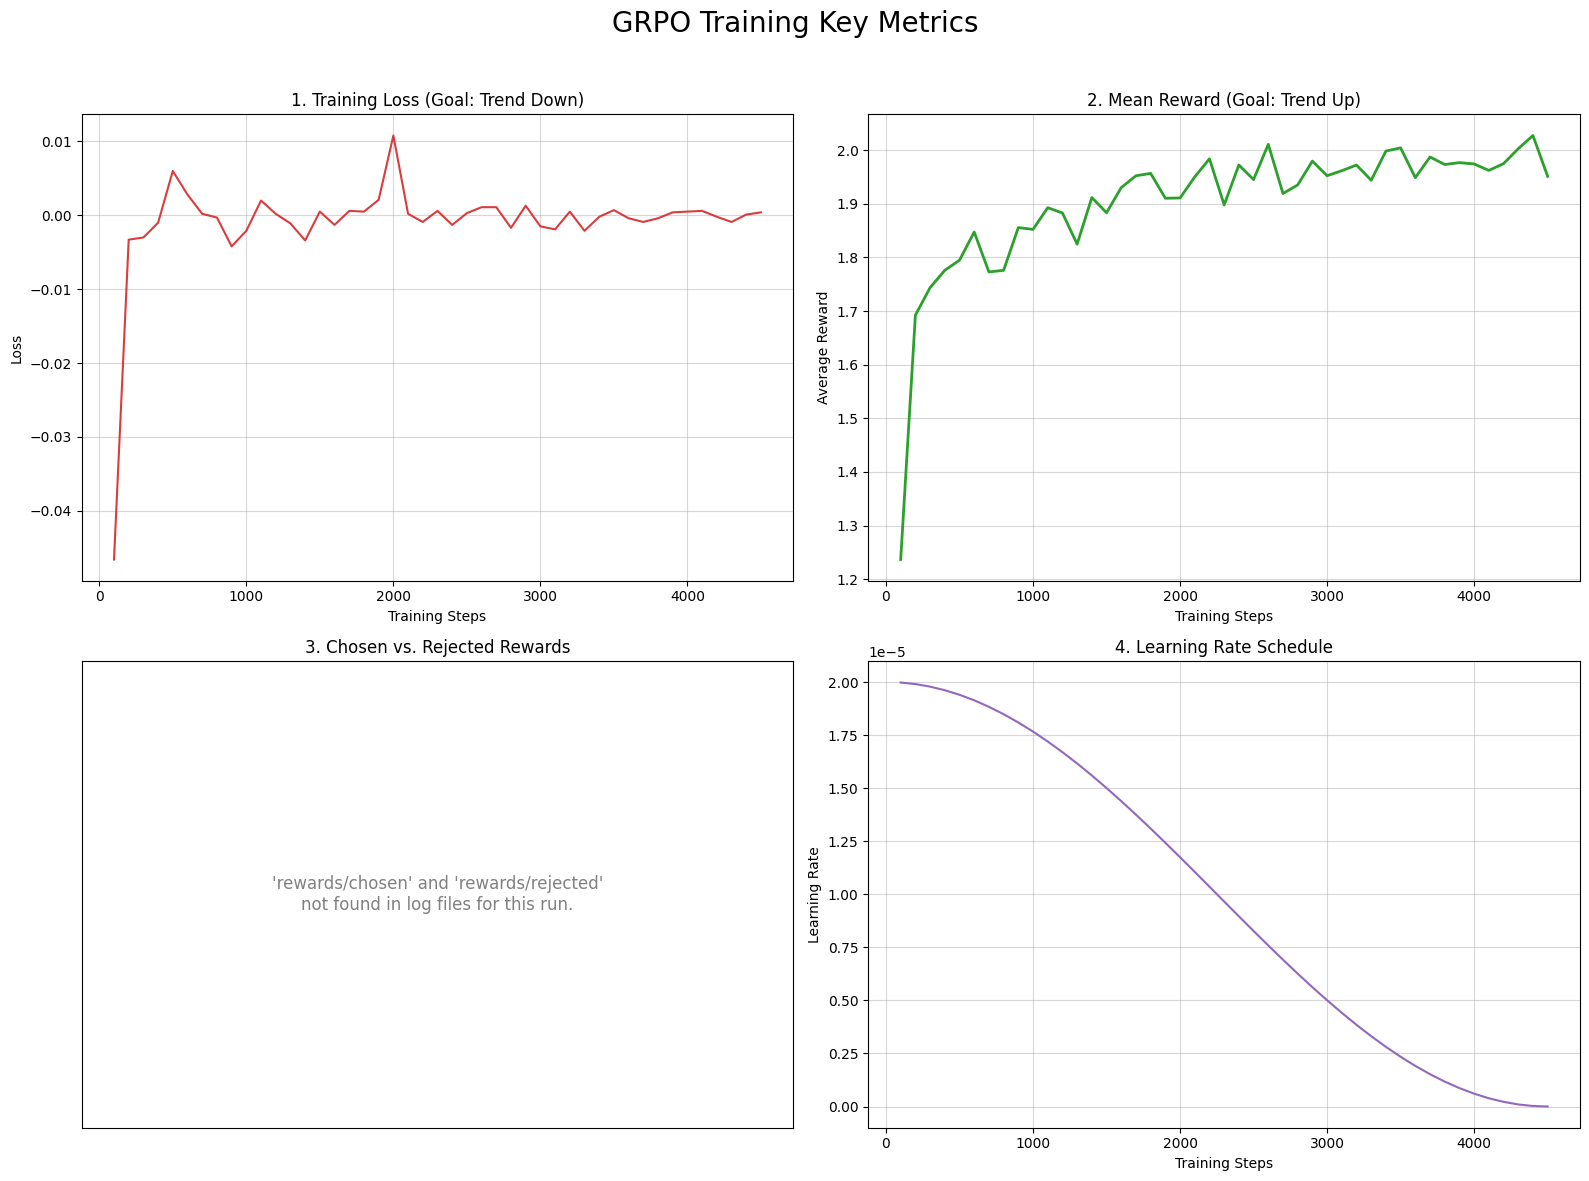

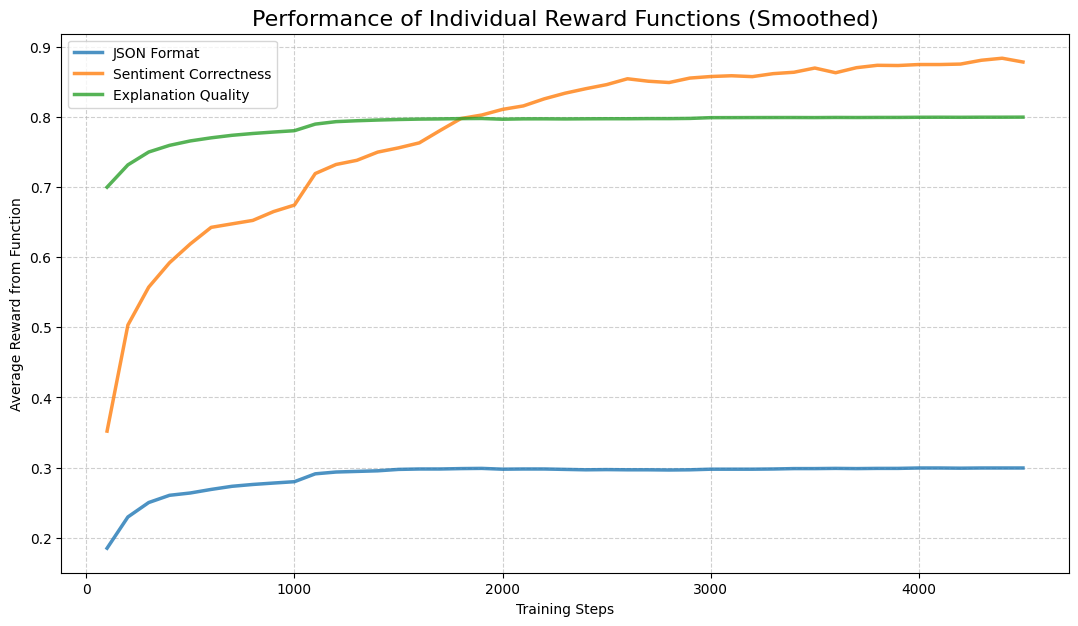

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorboard.backend.event_processing import event_accumulator

# --- Configuration ---
LOG_DIR = "logs/grpo-json"

# **CORRECTED**: We now map the EXACT metric names found in your logs
# to the desired, human-readable labels for the plot.
REWARD_METRIC_MAPPING = {
    "train/rewards/json_format_reward_func/mean": "JSON Format",
    "train/rewards/correct_sentiment_func/mean": "Sentiment Correctness",
    "train/rewards/explanation_quality_func/mean": "Explanation Quality",
}


# --- Helper Function to Load TensorBoard Data ---
def load_tensorboard_logs(log_dir):
    """Loads all scalar data from a TensorBoard log directory into pandas DataFrames."""
    data = {}
    event_file = None
    print(f"Searching for TensorBoard event file in: {os.path.abspath(log_dir)}")
    for root, dirs, files in os.walk(log_dir):
        for file in files:
            if "events.out.tfevents" in file:
                event_file = os.path.join(root, file)
                break
    if not event_file:
        print(f"\n--- ERROR: No TensorBoard event file found in '{log_dir}'. ---\n")
        return None

    print(f"Found event file: {event_file}")
    accumulator = event_accumulator.EventAccumulator(
        event_file, size_guidance={"scalars": 0}
    )
    accumulator.Reload()
    tags = accumulator.Tags()["scalars"]
    for tag in tags:
        events = accumulator.Scalars(tag)
        data[tag] = pd.DataFrame(
            {"step": [e.step for e in events], "value": [e.value for e in events]}
        )
    return data


# --- Load the Data ---
log_data = load_tensorboard_logs(LOG_DIR)

if log_data:
    # --- Plotting the Key Metrics ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("GRPO Training Key Metrics", fontsize=20)

    # Plot 1: Training Loss
    if "train/loss" in log_data:
        ax = axs[0, 0]
        df = log_data["train/loss"]
        ax.plot(df["step"], df["value"], color="tab:red", alpha=0.9)
        ax.set_title("1. Training Loss (Goal: Trend Down)")
        ax.grid(True, alpha=0.5)
        ax.set_xlabel("Training Steps")
        ax.set_ylabel("Loss")

    # Plot 2: Mean Reward (Using the correct metric 'train/reward')
    if "train/reward" in log_data:
        ax = axs[0, 1]
        df = log_data["train/reward"]
        ax.plot(df["step"], df["value"], color="tab:green", linewidth=2)
        ax.set_title("2. Mean Reward (Goal: Trend Up)")
        ax.grid(True, alpha=0.5)
        ax.set_xlabel("Training Steps")
        ax.set_ylabel("Average Reward")

    # Plot 3: Chosen vs. Rejected Rewards (Data not available in logs)
    ax = axs[1, 0]
    ax.text(
        0.5,
        0.5,
        "'rewards/chosen' and 'rewards/rejected'\nnot found in log files for this run.",
        ha="center",
        va="center",
        fontsize=12,
        color="gray",
    )
    ax.set_title("3. Chosen vs. Rejected Rewards")
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot 4: Learning Rate
    if "train/learning_rate" in log_data:
        ax = axs[1, 1]
        df = log_data["train/learning_rate"]
        ax.plot(df["step"], df["value"], color="tab:purple")
        ax.set_title("4. Learning Rate Schedule")
        ax.grid(True, alpha=0.5)
        ax.set_xlabel("Training Steps")
        ax.set_ylabel("Learning Rate")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Plotting Individual Reward Function Performance ---
    plt.figure(figsize=(13, 7))
    plt.title("Performance of Individual Reward Functions (Smoothed)", fontsize=16)

    available_tags = set(log_data.keys())

    # Iterate through our corrected mapping dictionary
    for tag_name, plot_label in REWARD_METRIC_MAPPING.items():
        if tag_name in available_tags:
            df = log_data[tag_name]
            smoothed_value = df["value"].rolling(window=10, min_periods=1).mean()
            plt.plot(
                df["step"], smoothed_value, label=plot_label, linewidth=2.5, alpha=0.8
            )
        else:
            print(
                f"--> Warning: Metric '{tag_name}' for label '{plot_label}' not found in logs. Skipping."
            )

    plt.xlabel("Training Steps")
    plt.ylabel("Average Reward from Function")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()